In [15]:
import numpy as np
import scipy.stats as sts
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import scipy.optimize as opt
import scipy.special as spc
import scipy

# Problem 1

## a)

In [332]:
pts = np.loadtxt('data/clms.txt')
pts_sub = pts[pts <= 800]
weight1 = np.ones(pts.shape[0])/pts.shape[0]
weight2 = np.ones(pts_sub.shape[0])/pts_sub.shape[0]

count, bins, ignored = plt.hist(pts, 1000, weights = weight1)
plt.show()

In [333]:
count, bins, ignored = plt.hist(pts_sub, 100, weights = weight2)
plt.show()

In [334]:
print('Mean is {}'.format(pts.mean()))
print('Median is {}'.format(np.median(pts)))
print('Max is {}'.format(pts.max()))
print('Min is {}'.format(pts.min()))
print('Std is {}'.format(pts.std()))

Mean is 720.2779753272437
Median is 172.21
Max is 227967.25
Min is 0.01
Std is 3972.663756393663


## b)

In [335]:

def ga_pdf(xvals, params):
    '''
    --------------------------------------------------------------------
    Generate pdf values from the normal pdf with mean mu and standard
    deviation sigma. If the cutoff is given, then the PDF values are
    inflated upward to reflect the zero probability on values above the
    cutoff. If there is no cutoff given, this function does the same
    thing as sp.stats.norm.pdf(x, loc=mu, scale=sigma).
    --------------------------------------------------------------------
    INPUTS:
    xvals  = (N,) vector, values of the normally distributed random
             variable
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    cutoff = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar upper bound value of distribution. Values above
             this value have zero probability
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION: None
    
    OBJECTS CREATED WITHIN FUNCTION:
    prob_notcut = scalar 
    pdf_vals = (N,) vector, normal PDF values for mu and sigma
               corresponding to xvals data
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: pdf_vals
    --------------------------------------------------------------------
    '''
    alpha, beta = params
    gamma = lambda x: x**(alpha - 1)*np.e**(-x)
            
#     pdf_vals    = xvals**(alpha - 1) * np.e **(-xvals/beta)/(beta ** alpha * integrate.quad(gamma, 0, 1e+3)[0])
    pdf_vals    = xvals**(alpha - 1) * np.exp(-xvals/beta)/(beta ** alpha * spc.gamma(alpha))
    
    return pdf_vals

def log_lik_trnorm(f, xvals, params):
    pdf_vals = f(xvals, params)
    pdf_vals[pdf_vals <= 0] = 1e-10
    ln_pdf_vals = np.log(pdf_vals)
    log_lik_val = ln_pdf_vals.sum()
    
    return log_lik_val

def crit(params, *args):
    xvals, f = args
    log_lik_val = log_lik_trnorm(f, xvals, params)
    neg_log_lik_val = -log_lik_val
    
    return neg_log_lik_val

In [336]:
beta_init = np.var(pts)/pts.mean()
alpha_init = pts.mean()/beta_init
params_init = np.array([alpha_init, beta_init])
# params_init = np.array([1, 1])
mle_args = (pts, ga_pdf)
results_ga = opt.minimize(crit, params_init, args=(mle_args), method = 'L-BFGS-B', \
                      bounds = ((1e-10, None), (1e-10, None)),\
                      tol = 1e-10)
alpha_ga_MLE, beta_ga_MLE = results_ga.x
print('alpha_MLE=', alpha_ga_MLE, ' beta_MLE=', beta_ga_MLE)

alpha_MLE= 0.221755322727  beta_MLE= 21911.0646992


In [337]:
results_ga

      fun: 82076.451605662558
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.        ,  0.09022187])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 33
      nit: 8
   status: 0
  success: True
        x: array([  2.21755323e-01,   2.19110647e+04])

In [338]:
log_lik_ga = log_lik_trnorm(ga_pdf, pts, results_ga.x)
print('Log liklihood is ', log_lik_ga)

Log liklihood is  -82076.4516057


<IPython.core.display.Javascript object>


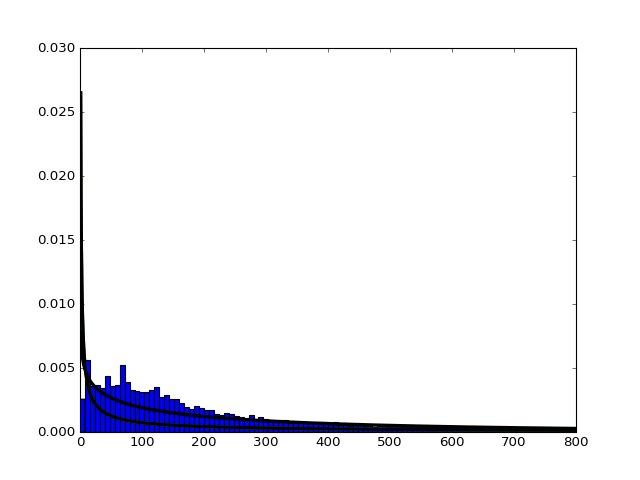

In [339]:
%matplotlib notebook

x_range = np.linspace(1, 800, 10000)
pdf_range = ga_pdf(x_range, results_ga.x)
count, bins, ignored = plt.hist(pts_sub, 100, weights = weight2, normed = True)
plt.plot(x_range, pdf_range, lw = 3)

## c)

In [340]:
def gg_pdf(xvals, params):
    alpha, beta, m = params
    gamma = lambda x: x**(alpha - 1)*np.e**(-x)
    pdf_vals    = m * xvals**(alpha - 1) * np.exp(-(xvals/beta)**m)/(beta ** alpha * spc.gamma(alpha/m))
    
    return pdf_vals

In [341]:
params_init = np.array([alpha_ga_MLE, beta_ga_MLE, 1])
# params_init = np.array([1, 1])
mle_args = (pts, gg_pdf)
results_gg = opt.minimize(crit, params_init, args=(mle_args), method = 'L-BFGS-B', \
                      bounds = ((1e-10, None), (1e-10, None), (1e-10, None)),\
                      tol = 1e-10)
alpha_gg_MLE, beta_gg_MLE, m_gg_MLE = results_gg.x

In [342]:
pdf_range = gg_pdf(x_range, results_gg.x)
plt.plot(x_range, pdf_range, lw = 3, color = 'black')

In [343]:
results_gg

      fun: 82076.446472453419
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.02328306,  0.09022187, -0.00582077])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 32
      nit: 4
   status: 0
  success: True
        x: array([  2.21753817e-01,   2.19110645e+04,   9.97649287e-01])

In [344]:
log_lik_gg = log_lik_trnorm(gg_pdf, pts, results_gg.x)
print('Log liklihood is ', log_lik_gg)

Log liklihood is  -82076.4464725


## d)

In [345]:
def gg2_pdf(xvals, params):
    a, b, p, q = params
    pdf_vals    = a * xvals**(a*p - 1) / (b**(a*p) * spc.beta(p, q) * (1 + (xvals/b)**a)**(p + q))
    
    return pdf_vals

In [346]:
params_init = np.array([m_gg_MLE, 1000 ** (1/m_gg_MLE) * beta_gg_MLE, alpha_gg_MLE / m_gg_MLE, 1000])
# params_init = np.array([1, 1])
mle_args = (pts, gg2_pdf)
results_gg2 = opt.minimize(crit, params_init, args=(mle_args), method = 'L-BFGS-B', \
                      bounds = ((1e-10, None), (1e-10, None), (1e-10, None), (1e-10, None)),\
                      tol = 1e-12)
a, b, p, q = results_gg2.x
results_gg2

      fun: 76083.495670897508
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.1193257 ,  0.        , -0.73341653,  0.61118044])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 185
      nit: 18
   status: 0
  success: True
        x: array([  5.98225208e-01,   2.22706162e+07,   1.37340161e+00,
         1.00021686e+03])

In [347]:
pdf_range = gg2_pdf(x_range, results_gg2.x)
plt.plot(x_range, pdf_range, lw = 3, color = 'black')

In [348]:
log_lik_gg2 = log_lik_trnorm(gg2_pdf, pts, results_gg2.x)
print('Log liklihood is ', log_lik_gg2)

Log liklihood is  -76083.4956709


## e)

In [349]:
#test ga and gg
LR_val_ga = 2 * (log_lik_ga - log_lik_gg2)
LR_val_gg = 2 * (log_lik_gg - log_lik_gg2)
pval_ga_h0 = 1.0 - sts.chi2.cdf(LR_val_ga, 4)
pval_gg_h0 = 1.0 - sts.chi2.cdf(LR_val_gg, 4)
print('chi squared of H0 for GA distribution with 4 degrees of freedom p-value = ', pval_ga_h0)
print('chi squared of H0 for GG distribution with 4 degrees of freedom p-value = ', pval_gg_h0)

chi squared of H0 for GA distribution with 4 degrees of freedom p-value =  1.0
chi squared of H0 for GG distribution with 4 degrees of freedom p-value =  1.0


## f)

In [350]:
prob1000_gg2 = 1.0 - gg2_pdf(1000, results_gg2.x)
prob1000_ga = 1.0 - ga_pdf(1000, results_ga.x)
print('Using GG2 distribution the probability is {}'.format(prob1000_gg2))
print('Using GA distribution the probability is {}'.format(prob1000_ga))

Using GG2 distribution the probability is 0.999806211381831
Using GA distribution the probability is 0.9998829333345131


# Problem 2

## a)

In [351]:
macro = np.genfromtxt('data/MacroSeries.txt',delimiter=',')

In [352]:
def get_z(xvals, params):
    alpha, rho, mu, sigma = params
    c, k, w, r = xvals.T
    z = np.log(w/((1 - alpha) * k**alpha))
    return z

def macro_pdf(xvals, params):
    alpha, rho, mu, sigma = params
    c, k, w, r = xvals.T
    z = np.log(w/((1 - alpha) * k ** alpha))
#     z_lag = z.shift()
    eps = z - rho * np.append([mu], z[:-1]) - (1 - rho) * mu
#     eps = z[1:] - rho * z[:-1] - (1 - rho) * mu
#     eps = z - rho * z_lag - (1 - rho) * mu
    pdf_vals    = (1/(sigma * np.sqrt(2 * np.pi)) *
                    np.exp( - (eps)**2 / (2 * sigma**2)))
    return pdf_vals

In [353]:
params_init = np.array([0.42, 0.8, 9.0, 0.3])
mle_args = (macro, macro_pdf)
results_macro = opt.minimize(crit, params_init, args=(mle_args), method = 'L-BFGS-B', \
                      bounds = ((1e-10, 1-1e-10), (-1 + 1e-10, 1 - 1e-10), (None, None), (1e-10, None)),\
                      tol = 1e-12)
results_macro

      fun: -96.706908070814464
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([  9.49285095e-04,   3.97903932e-05,   6.39488462e-05,
         3.59534624e-04])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 335
      nit: 33
   status: 0
  success: True
        x: array([ 0.45751568,  0.72048997,  9.52272852,  0.09199625])

## b)

In [354]:
def macro_pdf2(xvals, params):
    alpha, rho, mu, sigma = params
    c, k, w, r = xvals.T
    z = np.log(r/(alpha * k ** (alpha - 1)))
    eps = z - rho * np.append([mu], z[:-1]) - (1 - rho) * mu
#     eps = z - rho * z_lag - (1 - rho) * mu
    pdf_vals    = (1/(sigma * np.sqrt(2 * np.pi)) *
                    np.exp( - (eps)**2 / (2 * sigma**2)))
    return pdf_vals

In [355]:
params_init = np.array([0.4, 0, 0.1, 0.3])
params_init = np.array([0.42, 0.8, 2, 0.3])
mle_args = (macro, macro_pdf2)
results_macro2 = opt.minimize(crit, params_init, args=(mle_args), method = 'L-BFGS-B', \
                      bounds = ((1e-10, 1.01-1e-10), (-1 + 1e-10, 1 - 1e-10), (None, None), (1e-10, None)),\
                      tol = 1e-12)
results_macro2

      fun: -96.706908028375949
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([  2.32063257e-03,  -3.41060513e-05,   1.30739863e-04,
        -9.42179668e-04])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 375
      nit: 37
   status: 0
  success: True
        x: array([ 0.45748163,  0.72051423,  9.37091648,  0.09199619])

## c)

In [356]:
kt = 7500000
zt_prev = 10
alpha_macro, rho_macro, mu_macro, sigma_macro =   results_macro.x
eps_thread = np.log(1/(alpha_macro * kt**(alpha_macro - 1))) - rho_macro * zt_prev - (1 - rho_macro) * mu_macro


In [357]:
1 - sts.norm.cdf(eps_thread, loc=0, scale=sigma_macro)

0.99999996692678184

In [358]:
sts.norm.cdf(eps_thread, loc=0, scale=sigma_macro)

3.3073218170505957e-08

In [359]:
sigma_macro

0.091996246451262698

# Problem 3

## a)

In [415]:
usincome = np.loadtxt('data/usincmoms.txt', delimiter = '\t')
usincome[:, 1] /= 1000

<IPython.core.display.Javascript object>


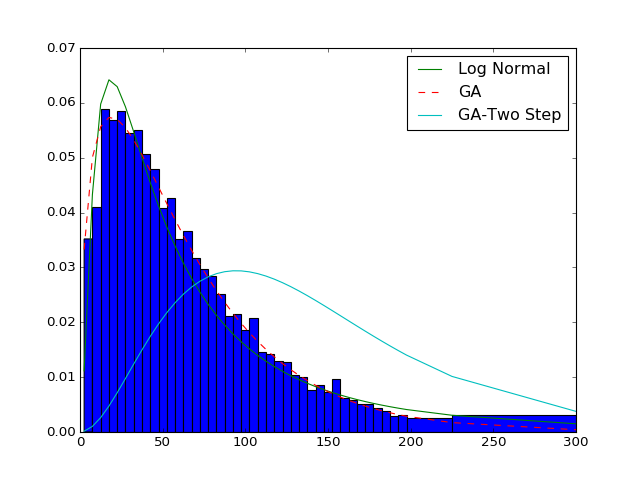

In [416]:
%matplotlib notebook
weight = np.ones(usincome.shape[0])/usincome.shape[0]
weight = usincome[:, 0].copy()
weight[-1] = weight[-1]/20
weight[-2] = weight[-2]/10
# weight *= usincome[:, 0]
count, bins, ignored = plt.hist(usincome[:, 1], bins = usincome[:, 1], weights = weight)


## b)

In [417]:
def income_datamom(data):
    datamoment = data[:, 0].copy()
    datamoment[-1] /= 20
    datamoment[-2] /= 10
    return datamoment

def income_modelmom_norm(mu, sigma):
    cutoffs = list(range(0, 205, 5))
    cutoffs.extend([250, 350])
    modelmom = np.zeros(len(cutoffs) - 1)
    for i in range(len(modelmom)):
        mom = sts.lognorm.cdf(cutoffs[i + 1], sigma, 0, mu)-\
            sts.lognorm.cdf(cutoffs[i], sigma, 0, mu)
        modelmom[i] = mom
    modelmom[-1] /= 20
    modelmom[-2] /= 10
    return modelmom

def LN_errvec(data, params):
    mu, sigma = params
    datamom = income_datamom(data)
    modelmom = income_modelmom_norm(mu, sigma)
    return (modelmom - datamom) / datamom

def income_crit(params, *args):
    data, W = args
    mu, sigma = params
    modelmom = income_modelmom_norm(mu, sigma)
    datamom = income_datamom(data)
    rela_error = (modelmom - datamom) / datamom
    return rela_error.T@ W@rela_error

In [418]:
mu_init = (weight * usincome[:, 1]).sum()
sigma_init = ((usincome[:, 1] - mu_init)**2 * weight).sum()
params_init = np.array([40, 0.2])
# params_init = np.array([50, 20])
# params_init = np.array([mu_init, sigma_init])
W = np.diag(weight)
gmm_args = (usincome, W * 100)
results_income = opt.minimize(income_crit, params_init, args=(gmm_args), method = 'Nelder-Mead', \
#                       bounds = ((None, None), (1e-10, None)),\
                    tol = 1e-12)
mu_inc, sigma_inc = results_income.x
results_income

 final_simplex: (array([[ 51.02903939,   1.01649377],
       [ 51.02903939,   1.01649377],
       [ 51.02903939,   1.01649377]]), array([ 3.03000255,  3.03000255,  3.03000255]))
           fun: 3.0300025538568987
       message: 'Optimization terminated successfully.'
          nfev: 226
           nit: 105
        status: 0
       success: True
             x: array([ 51.02903939,   1.01649377])

In [419]:
x_range = np.linspace(0, 350, 1000)
dense_LN = sts.lognorm.pdf(x_range, sigma_inc, 0, mu_inc)
dense_LN = income_modelmom_norm(mu_inc, sigma_inc)
plt.plot(usincome[:, 1], dense_LN, label = 'Log Normal')

## c)

In [420]:
usincome[:, 1].shape
dense_LN.shape

(42,)

In [421]:
def income_modelmom_ga(alpha, beta):
    cutoffs = list(range(0, 205, 5))
    cutoffs.extend([250, 350])
    modelmom = np.zeros(len(cutoffs) - 1)
    for i in range(len(modelmom)):
        mom = sts.gamma.cdf(cutoffs[i + 1], alpha, 0, beta)-\
            sts.gamma.cdf(cutoffs[i], alpha, 0, beta)
        modelmom[i] = mom
    modelmom[-1] /= 20
    modelmom[-2] /= 10
    return modelmom

def ga_errvec(data, params):
    alpha, beta = params
    modelmom = income_modelmom_ga(alpha, beta)
    datamom = income_datamom(data)
    return (modelmom - datamom) / datamom

def income_crit_ga(params, *args):
    data, W = args
    alpha, beta = params
    modelmom = income_modelmom_ga(alpha, beta)
    datamom = income_datamom(data)
    rela_error = (modelmom - datamom) / datamom
    return rela_error.T@ W@rela_error

In [422]:
alpha_init = 3
beta_init = 20000
params_init = np.array([alpha_init, beta_init])
W = np.diag(weight)
gmm_args = (usincome, W * 100)
results_income_ga = opt.minimize(income_crit_ga, params_init, args=(gmm_args), method = 'Nelder-Mead', \
#                       bounds = ((None, None), (1e-10, None)),\
                      tol = 1e-12)
alpha_inc, beta_inc = results_income_ga.x
results_income_ga

 final_simplex: (array([[  1.41684712,  44.91132453],
       [  1.41684712,  44.91132453],
       [  1.41684712,  44.91132453]]), array([ 0.62475362,  0.62475362,  0.62475362]))
           fun: 0.62475361593920997
       message: 'Optimization terminated successfully.'
          nfev: 386
           nit: 192
        status: 0
       success: True
             x: array([  1.41684712,  44.91132453])

In [423]:
dense_GA = sts.gamma.pdf(x_range, alpha_inc, 0, beta_inc)
dense_GA = income_modelmom_ga(alpha_inc, beta_inc)
plt.plot(usincome[:, 1], dense_GA, '--', label = 'GA')

In [424]:
dense_GA

array([ 0.0332702 ,  0.05005973,  0.05563832,  0.05734307,  0.05700037,
        0.05546207,  0.05320801,  0.05053514,  0.04763716,  0.04464412,
        0.04164456,  0.03869882,  0.03584753,  0.03311735,  0.03052486,
        0.02807935,  0.0257848 ,  0.02364141,  0.02164661,  0.01979593,
        0.01808359,  0.01650295,  0.01504686,  0.01370793,  0.0124787 ,
        0.0113518 ,  0.01032004,  0.00937647,  0.00851448,  0.00772776,
        0.00701036,  0.00635671,  0.00576159,  0.00522011,  0.00472777,
        0.00428036,  0.00387401,  0.00350514,  0.00317045,  0.00286691,
        0.00171082,  0.00041391])

## e)

In [425]:
error_LN = LN_errvec(usincome, results_income.x)
error_ga = ga_errvec(usincome, results_income_ga.x)
error_LN = error_LN.reshape((error_LN.shape[0], 1))
error_ga = error_ga.reshape((error_ga.shape[0], 1))
W_LN = error_LN.T @ error_LN
W_ga = error_ga @ error_ga.T * 100

alpha_init = alpha_inc + 1
beta_init = beta_inc
# alpha_init = 2
# beta_init = 45
# alpha_init = 3
# beta_init = 20000
params_init = np.array([alpha_init, beta_init])
gmm_args = (usincome, W_ga)
results_income_ga_two = opt.minimize(income_crit_ga, params_init, args=(gmm_args), method = 'L-BFGS-B', \
                      bounds = ((1e-10, None), (1e-10, None)),\
                      tol = 1e-12)
alpha_inc_two, beta_inc_two = results_income_ga_two.x
results_income_ga_two

      fun: 9.5810585781783207e-14
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -2.86910858e-06,  -3.68905073e-06])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 81
      nit: 5
   status: 0
  success: True
        x: array([  3.10012999,  44.99799236])

In [426]:
dense_GA_two = income_modelmom_ga(alpha_inc_two, beta_inc_two)
plt.plot(usincome[:, 1], dense_GA_two, label = 'GA-Two Step')
plt.legend()

# Problem 4

In [427]:
def macro_datamom(data, params):
    alpha, rho, mu, beta = params
    c, k, w, r = data.T
    z = get_z(data, params)
    z_lag = np.append([mu], z[:-1])
    
    #first moment
    first_mom = (z - rho * z_lag - (1- rho) * mu).mean()
    
    #second moment
    second_mom = ((z - rho * z_lag - (1- rho) * mu)*z_lag).mean()
    
    #third moment
    third_mom = (beta * alpha * np.exp(z[1:]) * k[1:]**(alpha - 1) * c[:-1] / c[1:] - 1).mean()
    
    #fourth moment
    fourth_mom = ((beta * alpha * np.exp(z[1:]) * k[1:]**(alpha - 1) * c[:-1] / c[1:] - 1) * w[:-1]).mean()
    
    return np.array([first_mom, second_mom, third_mom, fourth_mom])

def macro_gmm_crit(params, *args):
    data, W = args
    datamom = macro_datamom(data, params)
    modelmom = np.zeros(params.shape[0])
    error = datamom - modelmom
    error = error.reshape((error.shape[0],1))
    return error.T @ W @ error

In [428]:
params_init = np.append(results_macro.x[:3], [0.9])
# params_init = np.array([0.4, 0.5, 0.4, 0.6])
# params_init = np.array([0.42, 0.8, 2, 0.3])
gmm_args = (macro, np.eye(4))
results_macro_gmm = opt.minimize(macro_gmm_crit, params_init, args=(gmm_args), method = 'Nelder-Mead', \
#                       bounds = ((1e-10, None), (-1 + 1e-10, 1 - 1e-10), (1e-10, None), (1e-10, 1-1e-10)),\
                      tol = 1e-12, options = {'maxiter' : 15000})
alpha_gmm, rho_gmm, mu_gmm, sigma_gmm = results_macro_gmm.x
results_macro_gmm

 final_simplex: (array([[ 0.44389196,  0.71930335,  9.7142613 ,  0.89812829],
       [ 0.44389196,  0.71930335,  9.7142613 ,  0.89812829],
       [ 0.44389196,  0.71930335,  9.7142613 ,  0.89812829],
       [ 0.44389196,  0.71930335,  9.7142613 ,  0.89812829],
       [ 0.44389196,  0.71930335,  9.7142613 ,  0.89812829]]), array([  3.89327421e-10,   3.89327423e-10,   3.89327479e-10,
         3.89327508e-10,   3.89327527e-10]))
           fun: 3.8932742108532261e-10
       message: 'Optimization terminated successfully.'
          nfev: 3123
           nit: 1840
        status: 0
       success: True
             x: array([ 0.44389196,  0.71930335,  9.7142613 ,  0.89812829])

In [431]:
print('Estimated alpha is {}'.format(results_macro_gmm.x[0]))
print('Estimated rho is {}'.format(results_macro_gmm.x[1]))
print('Estimated mu is {}'.format(results_macro_gmm.x[2]))
print('Estimated beta is {}'.format(results_macro_gmm.x[3]))

Estimated alpha is 0.44389196474138715
Estimated rho is 0.7193033544309204
Estimated mu is 9.714261301726722
Estimated beta is 0.8981282936609406
